In [1]:
import matplotlib.pyplot as plt
from os import listdir
import os
from os.path import isfile, join
import json
import pandas as pd
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(1.33*11.7,1.33*8.27)})

In [2]:
paths = [
    '../logfiles/baseline/',
    '../logfiles/experiments/re_pruning/',
    '../logfiles/experiments/gd_top_k_mc_ac_dk/',
    
    '../logfiles/ablation_study/alexnet_mixed/',
    '../logfiles/ablation_study/resnet_mixed/',
    
    '../logfiles/ablation_study/admm_intra/',
    '../logfiles/ablation_study/admm_retrain/',
    
    '../logfiles/ablation_study/gd_top_k/',
    '../logfiles/ablation_study/gd_top_k_mc/',
    '../logfiles/ablation_study/gd_top_k_mc_ac/',
    '../logfiles/ablation_study/gd_top_k_mc_ac_dk/',
    '../logfiles/ablation_study/gd_top_k_mc_ac_dk_admm_intra/',
    '../logfiles/ablation_study/gd_top_k_mc_ac_dk_admm_retrain/',
    
    '../logfiles/ablation_study/re_pruning/',
    '../logfiles/ablation_study/re_pruning_admm_retrain/',
    '../logfiles/ablation_study/re_pruning_admm_intra/',
    '../logfiles/ablation_study/re_pruning_ac/',
    '../logfiles/ablation_study/re_pruning_ac_admm_intra/',
    '../logfiles/ablation_study/re_pruning_ac_admm_retrain/',
    '../logfiles/ablation_study/re_pruning_gd_top_k_mc_ac_dk_admm_intra/',
    '../logfiles/ablation_study/re_pruning_gd_top_k_mc_ac_dk_admm_retrain/'
        ]

In [3]:
def listdirs(rootdir, dirs):
    #https://www.techiedelight.com/list-all-subdirectories-in-directory-python/
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dirs.append(d+'/')
            #print(d)
            listdirs(d, dirs)
    return dirs
rootdir = '../logfiles/'
dirs = []
dirs = listdirs(rootdir, dirs)
dirs.append(rootdir)

In [4]:
paths = dirs
logs = []
for path in paths:
    print(path, flush=True)
    fnames = [f for f in listdir(path) if isfile(join(path, f))]
    for fname in fnames:
        #if 'vgg8' in fname:
        #    print(fname)
        if 'json' in fname:
            with open(path+fname, 'r') as f:
                logs.append(json.load(f))
        

../logfiles/ablation_study/
../logfiles/ablation_study/admm_intra/
../logfiles/ablation_study/admm_retrain/
../logfiles/ablation_study/alexnet_mixed/
../logfiles/ablation_study/gd_top_k/
../logfiles/ablation_study/gd_top_k_mc/
../logfiles/ablation_study/gd_top_k_mc_ac/
../logfiles/ablation_study/gd_top_k_mc_ac_dk/
../logfiles/ablation_study/gd_top_k_mc_ac_dk_admm_intra/
../logfiles/ablation_study/gd_top_k_mc_ac_dk_admm_retrain/
../logfiles/ablation_study/resnet_mixed/
../logfiles/ablation_study/re_pruning/
../logfiles/ablation_study/re_pruning_ac/
../logfiles/ablation_study/re_pruning_ac_admm_intra/
../logfiles/ablation_study/re_pruning_ac_admm_retrain/
../logfiles/ablation_study/re_pruning_admm_intra/
../logfiles/ablation_study/re_pruning_admm_retrain/
../logfiles/ablation_study/re_pruning_gd_top_k_mc_ac_dk_admm_intra/
../logfiles/ablation_study/re_pruning_gd_top_k_mc_ac_dk_admm_retrain/
../logfiles/baseline/
../logfiles/experiments/
../logfiles/experiments/gd_top_k_mc_ac_dk/
../logfi

In [5]:
def single_eval(dataset, model, name, specs_to_print, results_to_print, plt_corr = True):
    pd_dict = {}
    for log in logs:
        if (log['METADATA']['EXPERIMENT']['dataset'] == dataset and 
            log['METADATA']['EXPERIMENT']['name'] == name and
            log['METADATA']['EXPERIMENT']['model'] == model):
            #if log['LOGDATA']['test_accuracy'][-1] <= 0.1:
            #    continue
            outstring = model.upper() + ' ' + dataset.upper() + ' ' + name.upper() + '\n'
            for key in specs_to_print:
                section = None
                if key in log['METADATA']['SPECIFICATION']:
                    section = 'SPECIFICATION'
                if key in log['METADATA']['EXPERIMENT']:
                    section = 'EXPERIMENT'
                
                outstring += key + ':' + log['METADATA'][section][key] + '\n'
                if key not in pd_dict:
                    pd_dict[key] = []
                pd_dict[key].append(float(log['METADATA'][section][key]))
            #outstring += '\n'
            for key in results_to_print:
                if type(log['LOGDATA'][key]) == type([]):
                    outstring += key + ':' + str(round(log['LOGDATA'][key][-1], 2)) + '\n'
                    if key not in pd_dict:
                        pd_dict[key] = []
                    pd_dict[key].append(log['LOGDATA'][key][-1])
                else:
                    outstring += key + ':' + str(round(log['LOGDATA'][key], 2)) + '\n'
                    if key not in pd_dict:
                        pd_dict[key] = []
                    pd_dict[key].append(log['LOGDATA'][key])
                    
            #    if type(log['LOGDATA'][key]) == type([]):
            #        plt.plot(log['LOGDATA'][key], label=key)
            #plt.title(model.upper() + ' ' + dataset.upper() + ' ' + name.upper())
            #plt.legend()
            #plt.show()
            outstring+='\n'
            print(outstring)
                
    if plt_corr:
        pd_df = pd.DataFrame(pd_dict)
        if len(pd_df) > 0:
            pd_df = pd_df.loc[:, (pd_df != pd_df.iloc[0]).any()] #drop const cols
            sns.heatmap(pd_df.corr(), cbar=True, annot=True, cmap='RdBu')
            plt.title(model.upper() + ' ' + dataset.upper() + ' ' + name.upper())
            plt.xticks(rotation=45) 
            plt.show()
            
def cross_eval(best_results, datasets, models, name, specs_to_print, results_to_print, plt_corr = True):
    pd_dict = {}
    res_dict = {}
    best_config = {}
    prec = 2
    
    for model in models:
        for dataset in datasets:
            if model not in res_dict:
                res_dict[model] = {}
            if dataset not in res_dict[model]:
                res_dict[model][dataset] = {}
            if model not in best_config:
                best_config[model] = {}
            if dataset not in best_config[model]:
                best_config[model][dataset] = {}
            res_dict[model][dataset]['test_accuracy'] = 0.0
            res_dict[model][dataset]['total_su'] = 1.0
            res_dict[model][dataset]['current_su_fwd'] = 1.0
            res_dict[model][dataset]['current_sparsity'] = 0.0
            
            for log in logs:
                if (log['METADATA']['EXPERIMENT']['dataset'] == dataset and 
                    log['METADATA']['EXPERIMENT']['name'] == name and
                    log['METADATA']['EXPERIMENT']['model'] == model):
                    outstring = model.upper() + ' ' + dataset.upper() + ' ' + name.upper() + '\n'
                    #if log['LOGDATA']['test_accuracy'][-1] <= 0.1:
                    #    continue
                    if log['LOGDATA']['test_accuracy'][-1] > 1:
                        log['LOGDATA']['test_accuracy'] = [x * 1e-2 for x in log['LOGDATA']['test_accuracy']]
                        
                    #TODO = selectable . in rounding
                    
                    if round(res_dict[model][dataset]['test_accuracy'],prec) < round(log['LOGDATA']['test_accuracy'][-1],prec):
                        res_dict[model][dataset]['test_accuracy'] = log['LOGDATA']['test_accuracy'][-1]
                        if name != 'baseline':
                            res_dict[model][dataset]['current_su_fwd'] = log['LOGDATA']['current_su_fwd'][-1]
                            res_dict[model][dataset]['total_su'] = log['LOGDATA']['total_su'][-1]
                            res_dict[model][dataset]['current_sparsity'] = log['LOGDATA']['current_sparsity'][-1]
                            best_config[model][dataset]['METADATA'] = log['METADATA']
                    if round(res_dict[model][dataset]['test_accuracy'],prec) == round(log['LOGDATA']['test_accuracy'][-1],prec):
                        if name != 'baseline':
                            if round(res_dict[model][dataset]['total_su'],prec) < round(log['LOGDATA']['total_su'][-1],prec):
                                res_dict[model][dataset]['current_su_fwd'] = log['LOGDATA']['current_su_fwd'][-1]
                                res_dict[model][dataset]['test_accuracy'] = log['LOGDATA']['test_accuracy'][-1]
                                res_dict[model][dataset]['total_su'] = log['LOGDATA']['total_su'][-1]
                                res_dict[model][dataset]['current_sparsity'] = log['LOGDATA']['current_sparsity'][-1]
                                best_config[model][dataset]['METADATA'] = log['METADATA']
                    
                    for key in specs_to_print:
                        section = None
                        if key in log['METADATA']['SPECIFICATION']:
                            section = 'SPECIFICATION'
                        if key in log['METADATA']['EXPERIMENT']:
                            section = 'EXPERIMENT'

                        outstring += key + ':' + log['METADATA'][section][key] + '\n'
                        if key not in pd_dict:
                            pd_dict[key] = []
                        pd_dict[key].append(float(log['METADATA'][section][key]))
                    #outstring += '\n'
                    for key in results_to_print:
                        if type(log['LOGDATA'][key]) == type([]):
                            outstring += key + ':' + str(round(log['LOGDATA'][key][-1], prec)) + '\n'
                            if key not in pd_dict:
                                pd_dict[key] = []
                            pd_dict[key].append(log['LOGDATA'][key][-1])
                        else:
                            outstring += key + ':' + str(round(log['LOGDATA'][key], prec)) + '\n'
                            if key not in pd_dict:
                                pd_dict[key] = []
                            pd_dict[key].append(log['LOGDATA'][key])

                    #    if type(log['LOGDATA'][key]) == type([]):
                    #        plt.plot(log['LOGDATA'][key], label=key)
                    #plt.title(model.upper() + ' ' + dataset.upper() + ' ' + name.upper())
                    #plt.legend()
                    #plt.show()
                    outstring+='\n'
                    #print(outstring)
    for model in res_dict:
        for dataset in res_dict[model]:
            if res_dict[model][dataset]['test_accuracy'] > 0.0:
                #print(res_dict[model][dataset].keys())
                print('EXP.: {}, MODEL: {}, DATA: {}'.format(name, model, dataset))
                print('ACC.: {}, TRAIN SU: {}, INF. SU: {}, SP.: {}'.format(
                      round(res_dict[model][dataset]['test_accuracy'],prec),
                      round(res_dict[model][dataset]['total_su'],prec),
                      round(res_dict[model][dataset]['current_su_fwd'],prec),
                      round(res_dict[model][dataset]['current_sparsity'],prec)))
                #print(best_config[model][dataset])
    print('\n\n')
    if plt_corr:
        pd_df = pd.DataFrame(pd_dict)
        if len(pd_df) > 0:
            
            #pd_df = pd_df.loc[:, (pd_df != pd_df.iloc[0]).any()] #drop const cols
            corr = pd_df.corr()
            mask = np.zeros_like(corr, dtype=np.bool)
            mask[np.triu_indices_from(mask)] = True
            sns.heatmap(corr, mask=mask, cbar=True, square=True, annot=False, cmap='RdBu')
            plt.title(name.upper())
            plt.xticks(rotation=90) 
            plt.show()
            '''
            #for key in pd_df:
            #    pd_df.boxplot(column=key)
            #    plt.show()
            #pd_df.boxplot()
            #print(pd_df.describe(), flush=True)
            display(pd_df.describe())
            '''
            #pass
            
            for elem in results_to_print:
                pd_df.drop(elem,axis=1, inplace=True)
            cols = ['count','mean','std','min','max']
            col_names = [col.capitalize() for col in cols]
            print(pd_df.describe().transpose()[['count','mean','std','min','max']].to_latex(
                header=col_names,float_format="%.2f",bold_rows=True,
                caption="{}".format(name)))
            
    best_results[name] = {'cfg' : best_config, 'res': res_dict}

In [6]:
#TODO visualize hyperparameter distributions
#TODO correlate percentages ADMM as avaerages

EXP.: baseline, MODEL: resnet18, DATA: cifar10
ACC.: 0.75, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: resnet18, DATA: cifar100
ACC.: 0.43, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: resnet20, DATA: cifar10
ACC.: 0.8, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: resnet32, DATA: cifar10
ACC.: 0.81, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: resnet32, DATA: cifar100
ACC.: 0.47, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: resnet50, DATA: cifar10
ACC.: 0.74, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.74, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: alexnet_s, DATA: cifar100
ACC.: 0.41, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: mobilenet_v2, DATA: cifar10
ACC.: 0.77, TRAIN SU: 1.0, INF. SU: 1.0, SP.: 0.0
EXP.: baseline, MODEL: mobi

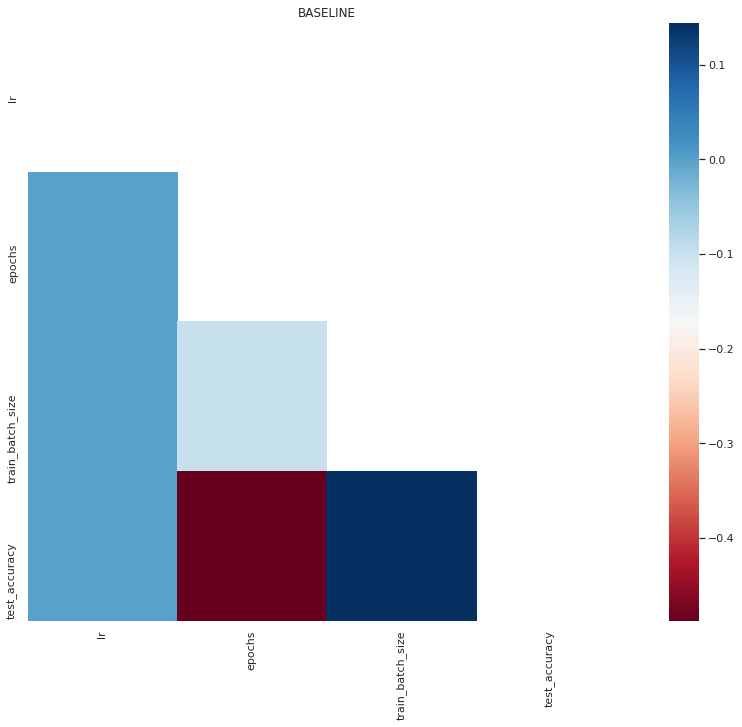

\begin{table}
\centering
\caption{baseline}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &   Mean &   Std &    Min &    Max \\
\midrule
\textbf{lr              } & 32.00 &   0.10 &  0.00 &   0.10 &   0.10 \\
\textbf{epochs          } & 32.00 &  94.38 & 22.13 &  10.00 & 100.00 \\
\textbf{train\_batch\_size} & 32.00 & 240.00 & 43.01 & 128.00 & 256.00 \\
\bottomrule
\end{tabular}
\end{table}

EXP.: admm_intra, MODEL: resnet18, DATA: cifar10
ACC.: 0.75, TRAIN SU: 2.48, INF. SU: 1.86, SP.: 0.71
EXP.: admm_intra, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.72, TRAIN SU: 2.17, INF. SU: 1.86, SP.: 0.98
EXP.: admm_intra, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 2.13, INF. SU: 12.01, SP.: 0.99





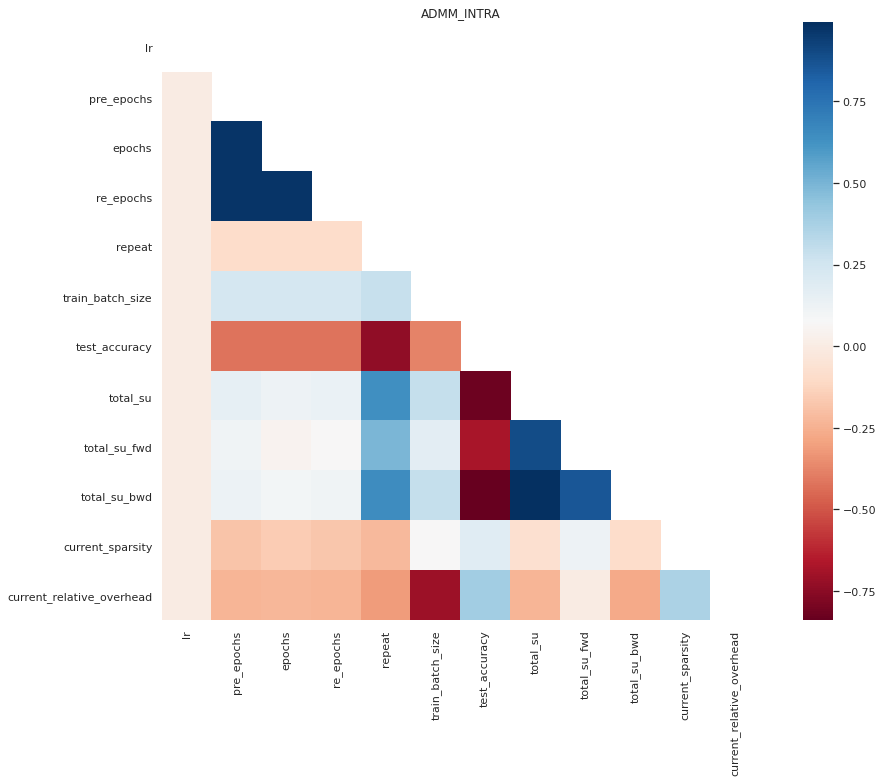

\begin{table}
\centering
\caption{admm_intra}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &   Mean &   Std &   Min &    Max \\
\midrule
\textbf{lr              } & 40.00 &   0.00 &  0.00 &  0.00 &   0.00 \\
\textbf{pre\_epochs      } & 40.00 &   2.20 &  2.61 &  1.00 &  11.00 \\
\textbf{epochs          } & 40.00 &   2.20 &  2.61 &  1.00 &  11.00 \\
\textbf{re\_epochs       } & 40.00 &   2.20 &  2.61 &  1.00 &  11.00 \\
\textbf{repeat          } & 40.00 &   5.40 &  8.29 &  2.00 &  33.00 \\
\textbf{train\_batch\_size} & 40.00 & 184.00 & 94.14 & 64.00 & 256.00 \\
\bottomrule
\end{tabular}
\end{table}

EXP.: admm_retrain, MODEL: resnet18, DATA: cifar10
ACC.: 0.7, TRAIN SU: 1.32, INF. SU: 1.86, SP.: 0.71
EXP.: admm_retrain, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.7, TRAIN SU: 1.53, INF. SU: 1.86, SP.: 0.98
EXP.: admm_retrain, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 1.8, INF. SU: 12.01, SP.: 0.99





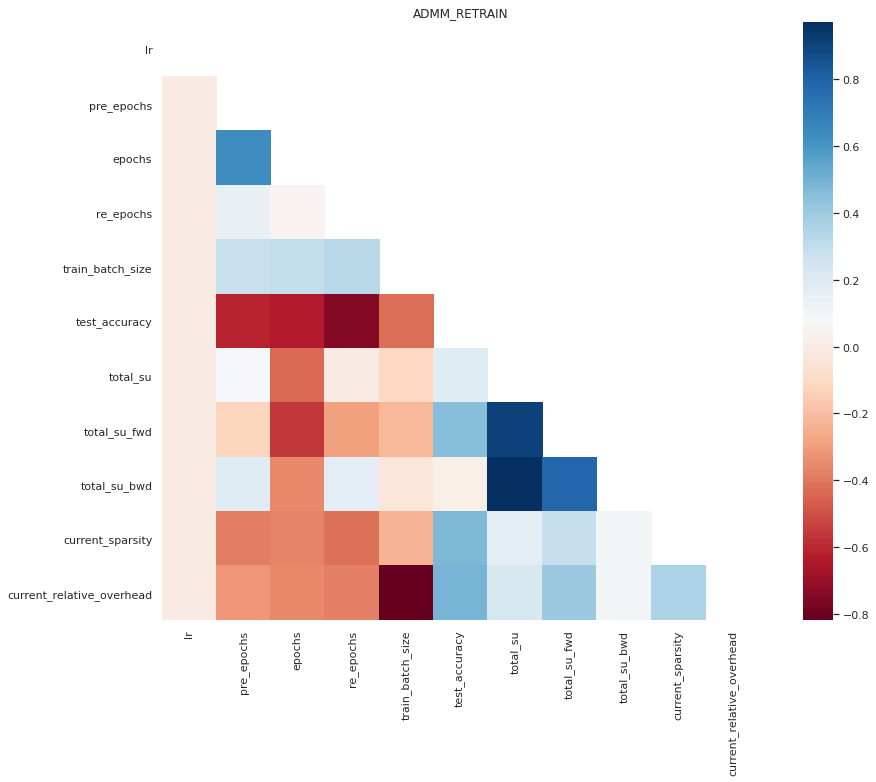

\begin{table}
\centering
\caption{admm_retrain}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &   Mean &   Std &   Min &    Max \\
\midrule
\textbf{lr              } & 39.00 &   0.00 &  0.00 &  0.00 &   0.00 \\
\textbf{pre\_epochs      } & 39.00 &   7.77 &  8.46 &  3.00 &  33.00 \\
\textbf{epochs          } & 39.00 &  12.77 & 17.42 &  3.00 &  66.00 \\
\textbf{re\_epochs       } & 39.00 &  14.77 & 24.63 &  3.00 &  94.00 \\
\textbf{train\_batch\_size} & 39.00 & 182.15 & 94.63 & 64.00 & 256.00 \\
\bottomrule
\end{tabular}
\end{table}

EXP.: gd_top_k, MODEL: resnet18, DATA: cifar10
ACC.: 0.76, TRAIN SU: 1.24, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.73, TRAIN SU: 1.48, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 2.1, INF. SU: 1.0, SP.: 0.0





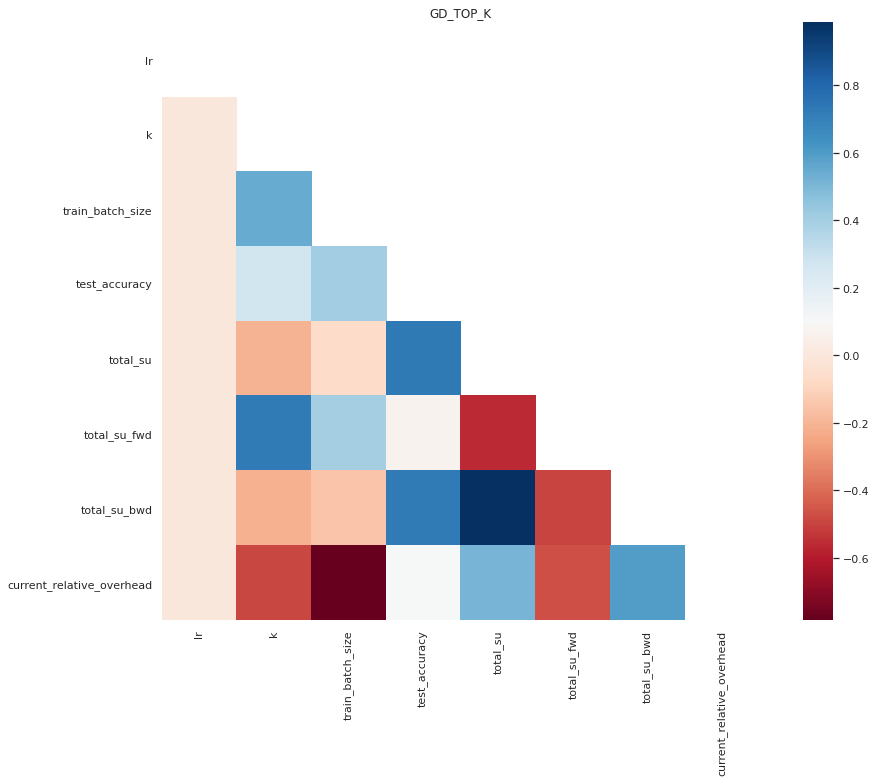

\begin{table}
\centering
\caption{gd_top_k}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &   Mean &   Std &   Min &    Max \\
\midrule
\textbf{lr              } & 36.00 &   0.00 &  0.00 &  0.00 &   0.00 \\
\textbf{k               } & 36.00 &   4.06 &  3.39 &  1.00 &  16.00 \\
\textbf{train\_batch\_size} & 36.00 & 170.67 & 96.76 & 64.00 & 256.00 \\
\bottomrule
\end{tabular}
\end{table}

EXP.: gd_top_k_mc, MODEL: resnet18, DATA: cifar10
ACC.: 0.77, TRAIN SU: 1.1, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.72, TRAIN SU: 1.47, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 2.06, INF. SU: 1.0, SP.: 0.0





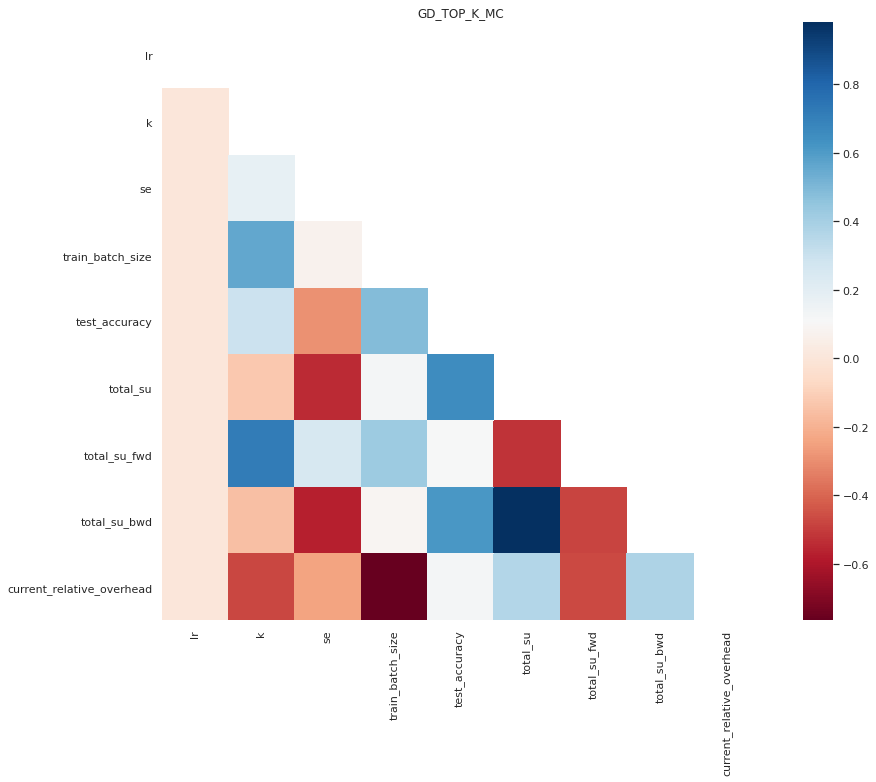

\begin{table}
\centering
\caption{gd_top_k_mc}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &   Mean &   Std &   Min &    Max \\
\midrule
\textbf{lr              } & 37.00 &   0.00 &  0.00 &  0.00 &   0.00 \\
\textbf{k               } & 37.00 &   4.16 &  3.40 &  1.00 &  16.00 \\
\textbf{se              } & 37.00 &   2.78 &  0.42 &  2.00 &   3.00 \\
\textbf{train\_batch\_size} & 37.00 & 172.97 & 96.43 & 64.00 & 256.00 \\
\bottomrule
\end{tabular}
\end{table}

EXP.: gd_top_k_mc_ac, MODEL: resnet18, DATA: cifar10
ACC.: 0.77, TRAIN SU: 1.51, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.71, TRAIN SU: 1.83, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 2.42, INF. SU: 1.0, SP.: 0.0





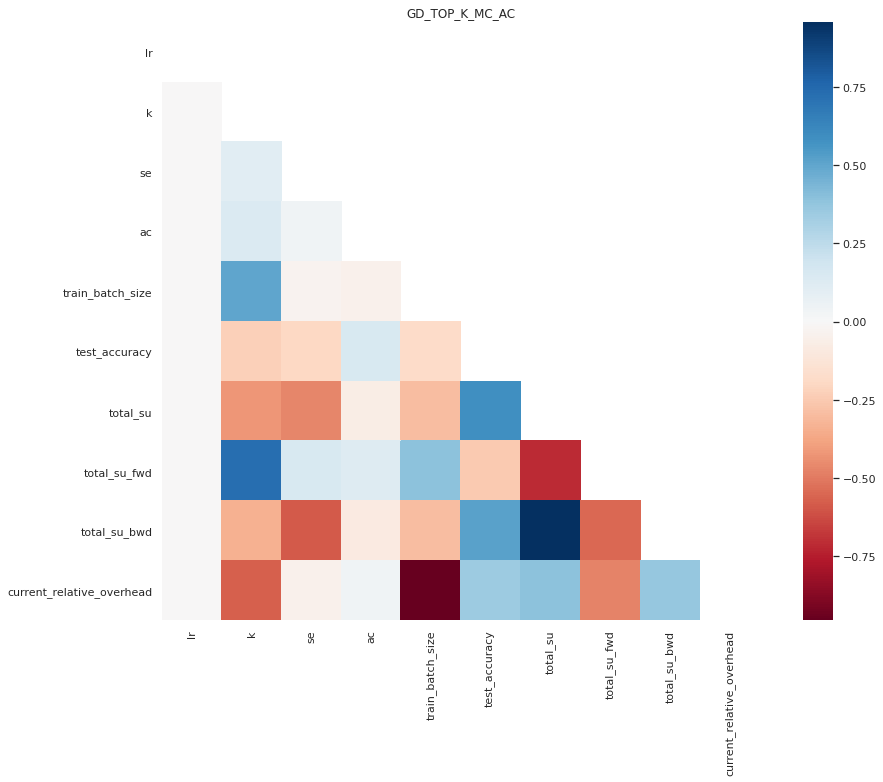

\begin{table}
\centering
\caption{gd_top_k_mc_ac}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &   Mean &   Std &   Min &    Max \\
\midrule
\textbf{lr              } & 52.00 &   0.00 &  0.00 &  0.00 &   0.00 \\
\textbf{k               } & 52.00 &   3.75 &  2.87 &  1.00 &  16.00 \\
\textbf{se              } & 52.00 &   2.85 &  0.36 &  2.00 &   3.00 \\
\textbf{ac              } & 52.00 &   6.85 &  3.46 &  2.00 &  12.00 \\
\textbf{train\_batch\_size} & 52.00 & 152.62 & 96.65 & 64.00 & 256.00 \\
\bottomrule
\end{tabular}
\end{table}

EXP.: gd_top_k_mc_ac_dk, MODEL: resnet18, DATA: cifar10
ACC.: 0.77, TRAIN SU: 1.46, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac_dk, MODEL: resnet18, DATA: cifar100
ACC.: 0.42, TRAIN SU: 1.41, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac_dk, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.73, TRAIN SU: 1.5, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac_dk, MODEL: alexnet_s, DATA: cifar100
ACC.: 0.37, TRAIN SU: 1.51, INF. SU: 1.0, SP.: 0.0
EXP.: gd_top_k_mc_ac_dk, MODEL: l

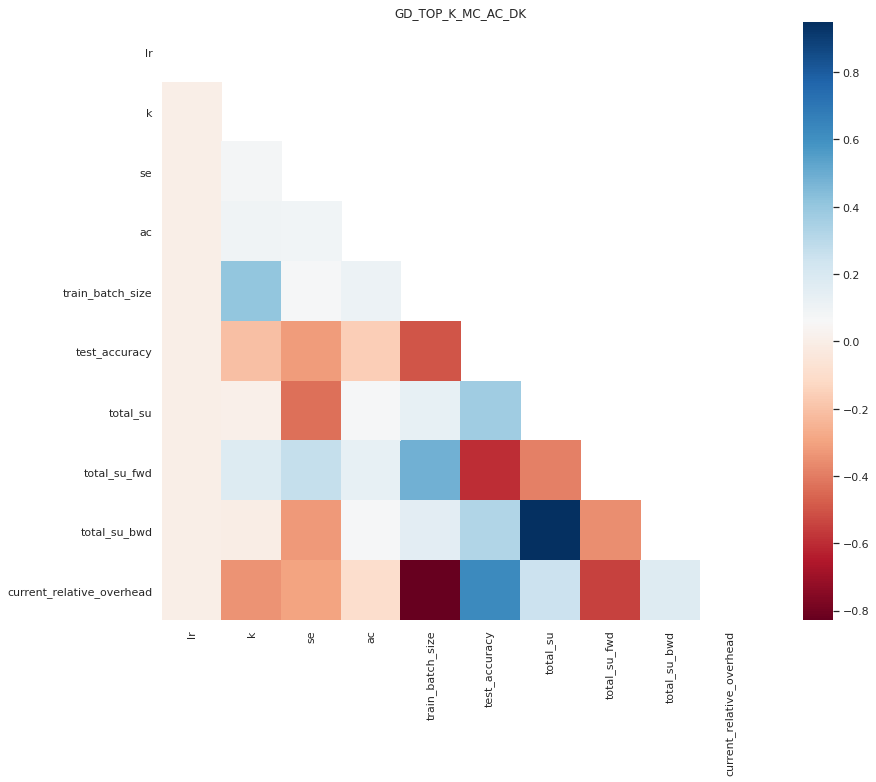

\begin{table}
\centering
\caption{gd_top_k_mc_ac_dk}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &   Mean &   Std &   Min &    Max \\
\midrule
\textbf{lr              } & 66.00 &   0.00 &  0.00 &  0.00 &   0.00 \\
\textbf{k               } & 66.00 &   3.41 &  2.58 &  1.00 &  16.00 \\
\textbf{se              } & 66.00 &   2.82 &  0.39 &  2.00 &   3.00 \\
\textbf{ac              } & 66.00 &   7.45 &  2.44 &  2.00 &  12.00 \\
\textbf{train\_batch\_size} & 66.00 & 173.58 & 94.44 & 64.00 & 256.00 \\
\bottomrule
\end{tabular}
\end{table}

EXP.: gd_top_k_mc_ac_dk_admm_intra, MODEL: resnet18, DATA: cifar10
ACC.: 0.75, TRAIN SU: 3.01, INF. SU: 1.86, SP.: 0.71
EXP.: gd_top_k_mc_ac_dk_admm_intra, MODEL: alexnet_s, DATA: cifar10
ACC.: 0.73, TRAIN SU: 2.69, INF. SU: 1.86, SP.: 0.98
EXP.: gd_top_k_mc_ac_dk_admm_intra, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 4.27, INF. SU: 4.42, SP.: 0.83





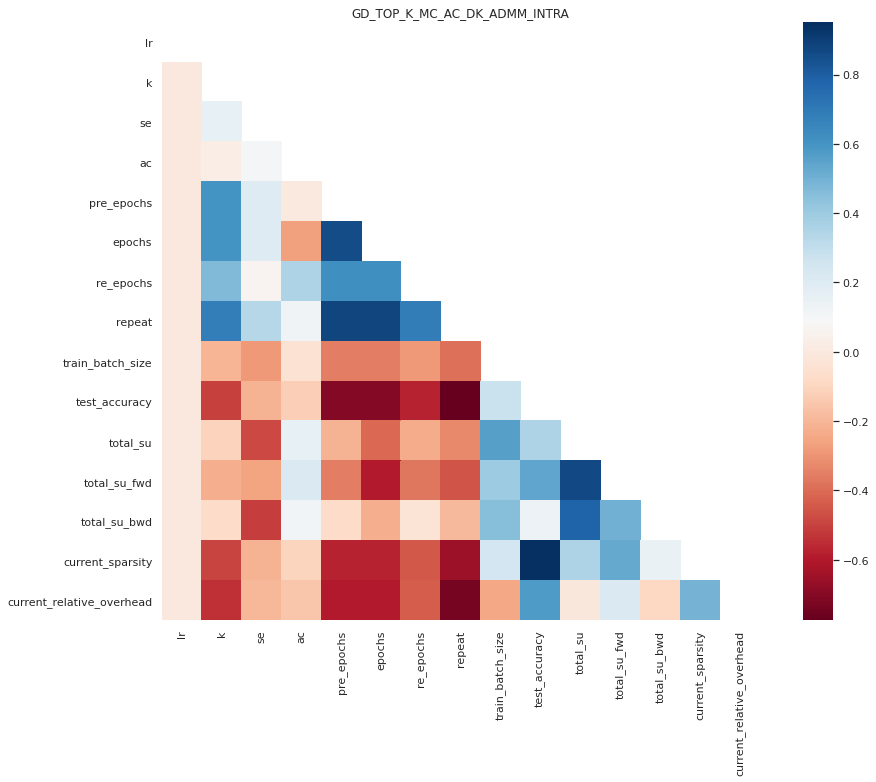

\begin{table}
\centering
\caption{gd_top_k_mc_ac_dk_admm_intra}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &   Mean &   Std &   Min &    Max \\
\midrule
\textbf{lr              } & 56.00 &   0.00 &  0.00 &  0.00 &   0.00 \\
\textbf{k               } & 56.00 &   4.57 &  4.00 &  1.00 &  16.00 \\
\textbf{se              } & 56.00 &   2.86 &  0.35 &  2.00 &   3.00 \\
\textbf{ac              } & 56.00 &   7.21 &  2.72 &  2.00 &  12.00 \\
\textbf{pre\_epochs      } & 56.00 &   1.93 &  0.89 &  1.00 &   3.00 \\
\textbf{epochs          } & 56.00 &   1.93 &  0.89 &  1.00 &   3.00 \\
\textbf{re\_epochs       } & 56.00 &   2.14 &  0.88 &  1.00 &   3.00 \\
\textbf{repeat          } & 56.00 &   5.43 &  4.21 &  2.00 &  11.00 \\
\textbf{train\_batch\_size} & 56.00 & 105.14 & 79.50 & 64.00 & 256.00 \\
\bottomrule
\end{tabular}
\end{table}

EXP.: gd_top_k_mc_ac_dk_admm_retrain, MODEL: lenet, DATA: mnist
ACC.: 0.99, TRAIN SU: 3.98, INF. SU: 12.01, SP.: 0.99





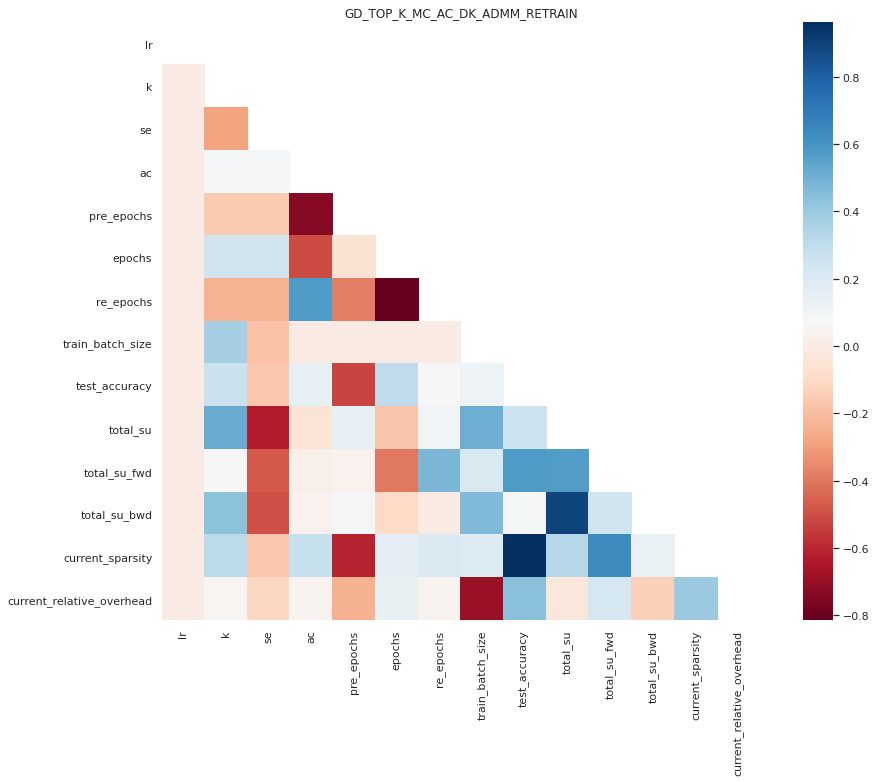

\begin{table}
\centering
\caption{gd_top_k_mc_ac_dk_admm_retrain}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &   Mean &   Std &   Min &    Max \\
\midrule
\textbf{lr              } & 36.00 &   0.00 &  0.00 &  0.00 &   0.00 \\
\textbf{k               } & 36.00 &   2.56 &  0.84 &  1.00 &   3.00 \\
\textbf{se              } & 36.00 &   2.78 &  0.42 &  2.00 &   3.00 \\
\textbf{ac              } & 36.00 &   7.00 &  3.26 &  2.00 &  12.00 \\
\textbf{pre\_epochs      } & 36.00 &   3.83 &  3.07 &  1.00 &  10.00 \\
\textbf{epochs          } & 36.00 &   4.17 &  1.98 &  1.00 &   6.00 \\
\textbf{re\_epochs       } & 36.00 &   6.00 &  4.57 &  2.00 &  14.00 \\
\textbf{train\_batch\_size} & 36.00 & 128.00 & 91.79 & 64.00 & 256.00 \\
\bottomrule
\end{tabular}
\end{table}

EXP.: re_pruning, MODEL: resnet18, DATA: cifar10
ACC.: 0.76, TRAIN SU: 1.22, INF. SU: 1.27, SP.: 0.96
EXP.: re_pruning, MODEL: resnet18, DATA: cifar100
ACC.: 0.42, TRAIN SU: 1.16, INF. SU: 1.19, SP.: 0.9
EXP.: re_pruning, MODEL: alex

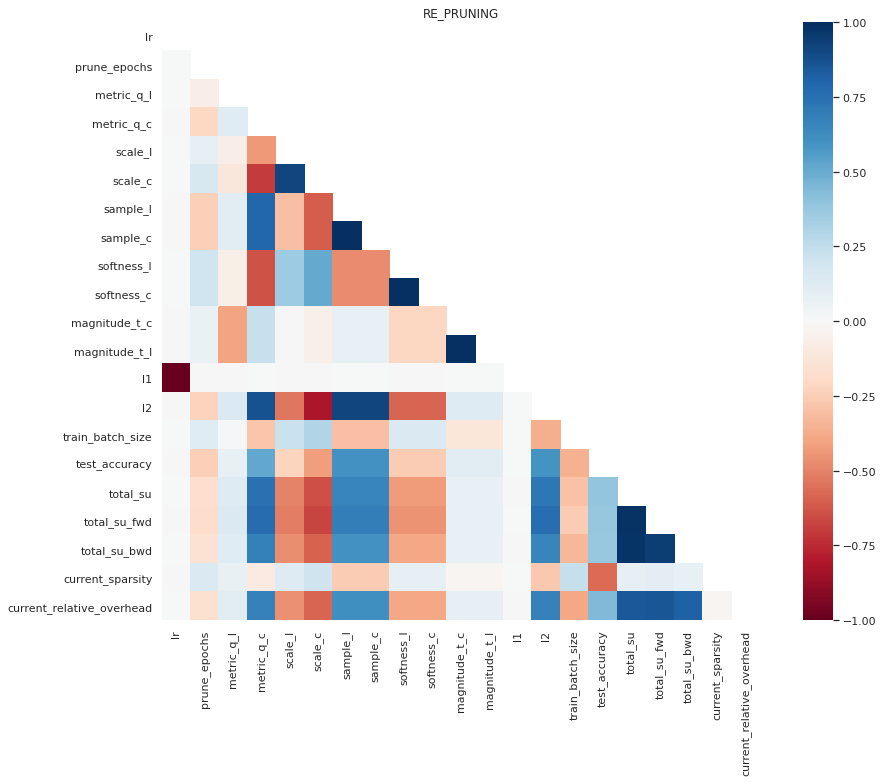

\begin{table}
\centering
\caption{re_pruning}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &   Mean &    Std &    Min &     Max \\
\midrule
\textbf{lr              } & 84.00 &   0.10 &   0.00 &   0.10 &    0.10 \\
\textbf{prune\_epochs    } & 84.00 &   2.43 &   3.45 &   0.00 &   20.00 \\
\textbf{metric\_q\_l      } & 84.00 &   0.02 &   0.05 &   0.00 &    0.33 \\
\textbf{metric\_q\_c      } & 84.00 &   0.07 &   0.06 &   0.03 &    0.25 \\
\textbf{scale\_l         } & 84.00 &   0.25 &   0.06 &   0.10 &    0.50 \\
\textbf{scale\_c         } & 84.00 &   0.24 &   0.08 &   0.01 &    0.50 \\
\textbf{sample\_l        } & 84.00 & 228.57 & 275.32 & 100.00 & 1000.00 \\
\textbf{sample\_c        } & 84.00 & 228.57 & 275.32 & 100.00 & 1000.00 \\
\textbf{softness\_l      } & 84.00 &   0.69 &   0.39 &   0.00 &    0.90 \\
\textbf{softness\_c      } & 84.00 &   0.69 &   0.39 &   0.00 &    0.90 \\
\textbf{magnitude\_t\_c   } & 84.00 &   0.00 &   0.00 &   0.00 &    0.00 \\
\textbf{magnitude\_t\_l   } & 84.0

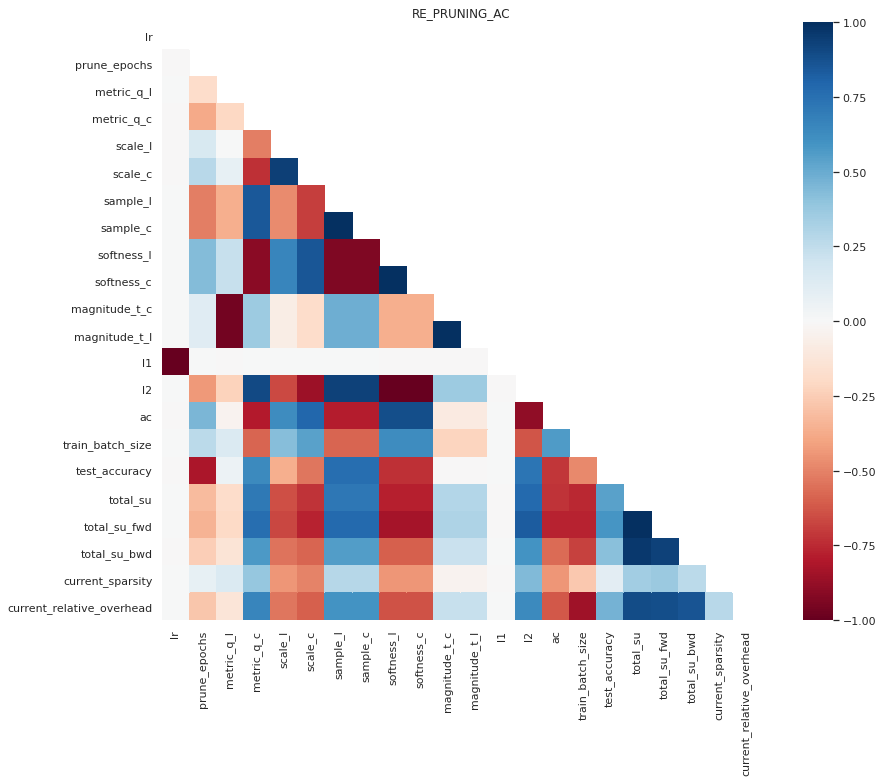

\begin{table}
\centering
\caption{re_pruning_ac}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &   Mean &    Std &    Min &     Max \\
\midrule
\textbf{lr              } & 29.00 &   0.10 &   0.00 &   0.10 &    0.10 \\
\textbf{prune\_epochs    } & 29.00 &   2.83 &   6.00 &   0.00 &   20.00 \\
\textbf{metric\_q\_l      } & 29.00 &   0.07 &   0.09 &   0.00 &    0.33 \\
\textbf{metric\_q\_c      } & 29.00 &   0.12 &   0.09 &   0.03 &    0.25 \\
\textbf{scale\_l         } & 29.00 &   0.23 &   0.12 &   0.10 &    0.50 \\
\textbf{scale\_c         } & 29.00 &   0.18 &   0.15 &   0.01 &    0.50 \\
\textbf{sample\_l        } & 29.00 & 586.21 & 406.84 & 100.00 & 1000.00 \\
\textbf{sample\_c        } & 29.00 & 586.21 & 406.84 & 100.00 & 1000.00 \\
\textbf{softness\_l      } & 29.00 &   0.50 &   0.46 &   0.00 &    0.90 \\
\textbf{softness\_c      } & 29.00 &   0.50 &   0.46 &   0.00 &    0.90 \\
\textbf{magnitude\_t\_c   } & 29.00 &   0.00 &   0.00 &   0.00 &    0.00 \\
\textbf{magnitude\_t\_l   } & 2

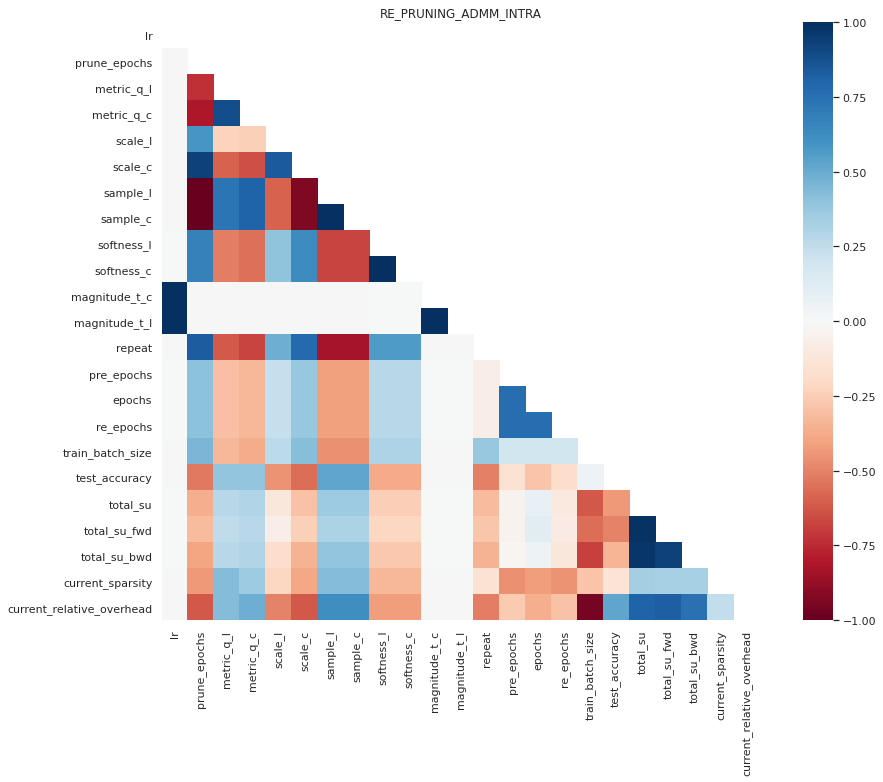

\begin{table}
\centering
\caption{re_pruning_admm_intra}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &   Mean &    Std &    Min &     Max \\
\midrule
\textbf{lr              } & 98.00 &   0.00 &   0.00 &   0.00 &    0.00 \\
\textbf{prune\_epochs    } & 98.00 &   0.53 &   0.89 &   0.00 &    2.00 \\
\textbf{metric\_q\_l      } & 98.00 &   0.03 &   0.02 &   0.00 &    0.05 \\
\textbf{metric\_q\_c      } & 98.00 &   0.17 &   0.09 &   0.05 &    0.25 \\
\textbf{scale\_l         } & 98.00 &   0.18 &   0.08 &   0.10 &    0.25 \\
\textbf{scale\_c         } & 98.00 &   0.10 &   0.10 &   0.01 &    0.25 \\
\textbf{sample\_l        } & 98.00 & 761.22 & 399.39 & 100.00 & 1000.00 \\
\textbf{sample\_c        } & 98.00 & 761.22 & 399.39 & 100.00 & 1000.00 \\
\textbf{softness\_l      } & 98.00 &   0.13 &   0.32 &   0.00 &    0.90 \\
\textbf{softness\_c      } & 98.00 &   0.13 &   0.32 &   0.00 &    0.90 \\
\textbf{magnitude\_t\_c   } & 98.00 &   0.00 &   0.00 &   0.00 &    0.00 \\
\textbf{magnitude\_t\_l

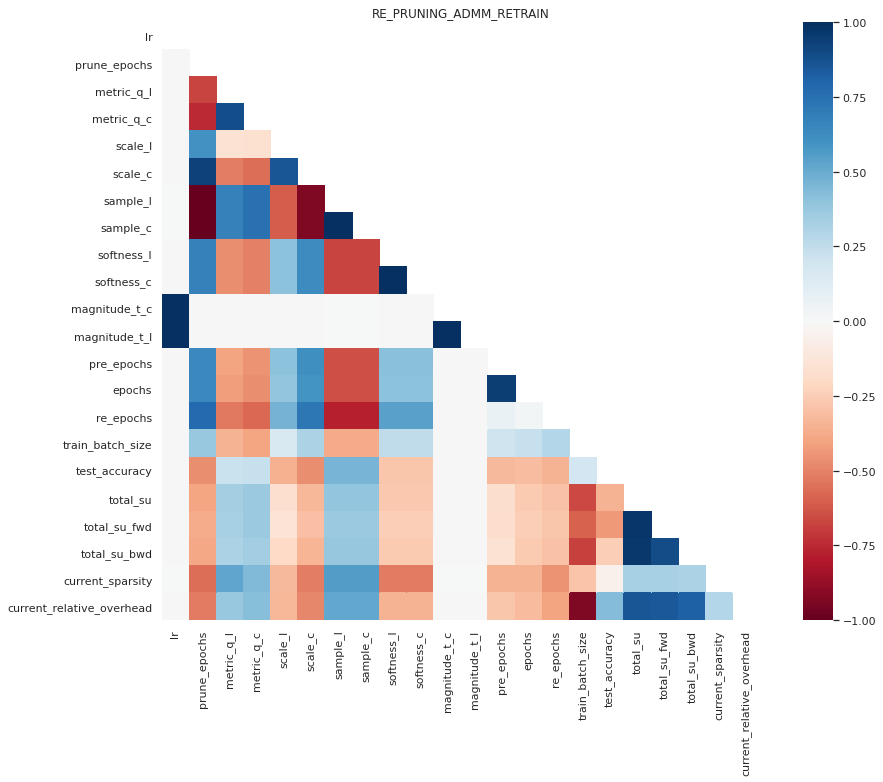

\begin{table}
\centering
\caption{re_pruning_admm_retrain}
\begin{tabular}{lrrrrr}
\toprule
{} &  Count &   Mean &    Std &    Min &     Max \\
\midrule
\textbf{lr              } & 110.00 &   0.00 &   0.00 &   0.00 &    0.00 \\
\textbf{prune\_epochs    } & 110.00 &   0.45 &   0.84 &   0.00 &    2.00 \\
\textbf{metric\_q\_l      } & 110.00 &   0.03 &   0.02 &   0.00 &    0.05 \\
\textbf{metric\_q\_c      } & 110.00 &   0.16 &   0.08 &   0.05 &    0.25 \\
\textbf{scale\_l         } & 110.00 &   0.17 &   0.07 &   0.10 &    0.25 \\
\textbf{scale\_c         } & 110.00 &   0.08 &   0.10 &   0.01 &    0.25 \\
\textbf{sample\_l        } & 110.00 & 795.45 & 378.89 & 100.00 & 1000.00 \\
\textbf{sample\_c        } & 110.00 & 795.45 & 378.89 & 100.00 & 1000.00 \\
\textbf{softness\_l      } & 110.00 &   0.11 &   0.29 &   0.00 &    0.90 \\
\textbf{softness\_c      } & 110.00 &   0.11 &   0.29 &   0.00 &    0.90 \\
\textbf{magnitude\_t\_c   } & 110.00 &   0.00 &   0.00 &   0.00 &    0.00 \\
\textbf{m

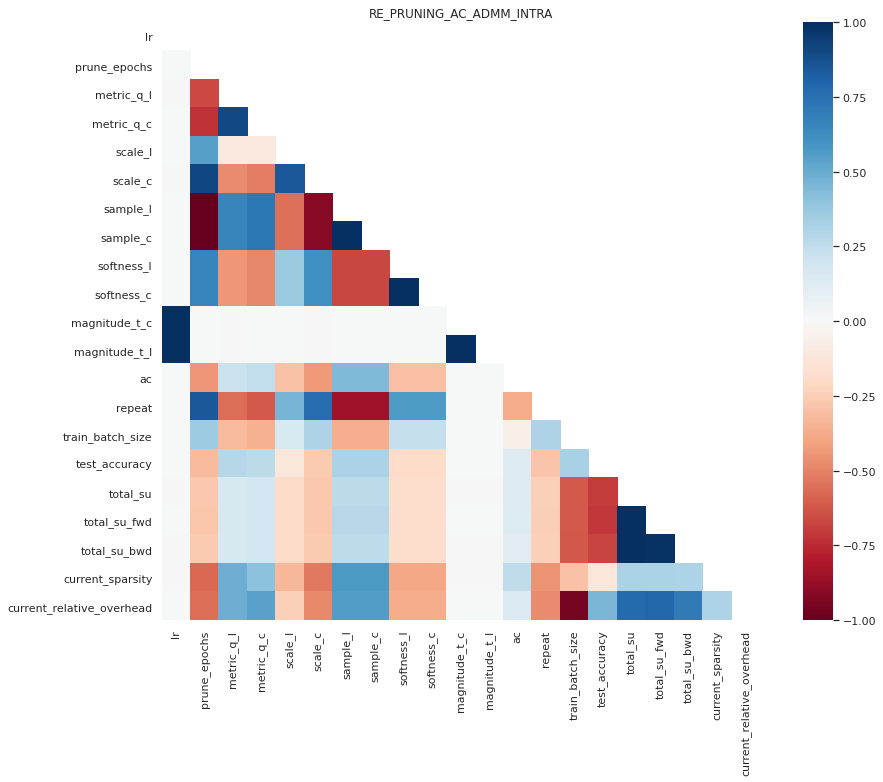

\begin{table}
\centering
\caption{re_pruning_ac_admm_intra}
\begin{tabular}{lrrrrr}
\toprule
{} &  Count &   Mean &    Std &    Min &     Max \\
\midrule
\textbf{lr              } & 128.00 &   0.00 &   0.00 &   0.00 &    0.00 \\
\textbf{prune\_epochs    } & 128.00 &   0.38 &   0.78 &   0.00 &    2.00 \\
\textbf{metric\_q\_l      } & 128.00 &   0.03 &   0.02 &   0.00 &    0.05 \\
\textbf{metric\_q\_c      } & 128.00 &   0.17 &   0.08 &   0.05 &    0.25 \\
\textbf{scale\_l         } & 128.00 &   0.16 &   0.07 &   0.10 &    0.25 \\
\textbf{scale\_c         } & 128.00 &   0.08 &   0.09 &   0.01 &    0.25 \\
\textbf{sample\_l        } & 128.00 & 831.25 & 352.66 & 100.00 & 1000.00 \\
\textbf{sample\_c        } & 128.00 & 831.25 & 352.66 & 100.00 & 1000.00 \\
\textbf{softness\_l      } & 128.00 &   0.08 &   0.26 &   0.00 &    0.90 \\
\textbf{softness\_c      } & 128.00 &   0.08 &   0.26 &   0.00 &    0.90 \\
\textbf{magnitude\_t\_c   } & 128.00 &   0.00 &   0.00 &   0.00 &    0.00 \\
\textbf{

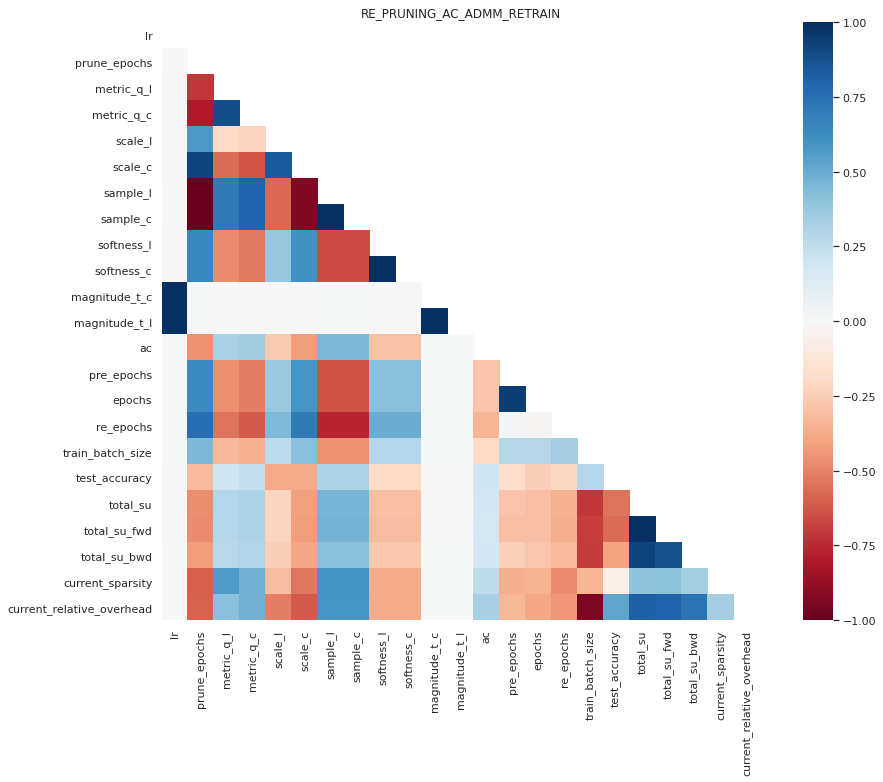

\begin{table}
\centering
\caption{re_pruning_ac_admm_retrain}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &   Mean &    Std &    Min &     Max \\
\midrule
\textbf{lr              } & 96.00 &   0.00 &   0.00 &   0.00 &    0.00 \\
\textbf{prune\_epochs    } & 96.00 &   0.50 &   0.87 &   0.00 &    2.00 \\
\textbf{metric\_q\_l      } & 96.00 &   0.03 &   0.02 &   0.00 &    0.05 \\
\textbf{metric\_q\_c      } & 96.00 &   0.17 &   0.09 &   0.05 &    0.25 \\
\textbf{scale\_l         } & 96.00 &   0.18 &   0.08 &   0.10 &    0.25 \\
\textbf{scale\_c         } & 96.00 &   0.09 &   0.10 &   0.01 &    0.25 \\
\textbf{sample\_l        } & 96.00 & 775.00 & 391.76 & 100.00 & 1000.00 \\
\textbf{sample\_c        } & 96.00 & 775.00 & 391.76 & 100.00 & 1000.00 \\
\textbf{softness\_l      } & 96.00 &   0.11 &   0.30 &   0.00 &    0.90 \\
\textbf{softness\_c      } & 96.00 &   0.11 &   0.30 &   0.00 &    0.90 \\
\textbf{magnitude\_t\_c   } & 96.00 &   0.00 &   0.00 &   0.00 &    0.00 \\
\textbf{magnitude\

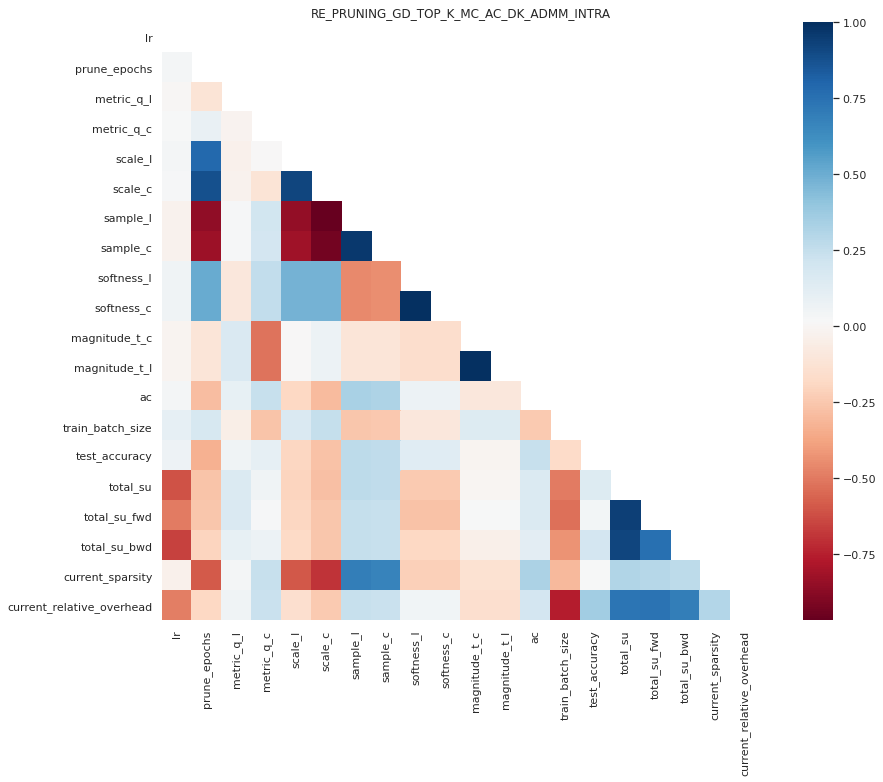

\begin{table}
\centering
\caption{re_pruning_gd_top_k_mc_ac_dk_admm_intra}
\begin{tabular}{lrrrrr}
\toprule
{} &  Count &   Mean &    Std &    Min &     Max \\
\midrule
\textbf{lr              } & 375.00 &   0.00 &   0.00 &   0.00 &    0.00 \\
\textbf{prune\_epochs    } & 375.00 &   0.54 &   0.89 &   0.00 &    2.00 \\
\textbf{metric\_q\_l      } & 375.00 &   0.05 &   0.01 &   0.03 &    0.10 \\
\textbf{metric\_q\_c      } & 375.00 &   0.07 &   0.06 &   0.05 &    0.25 \\
\textbf{scale\_l         } & 375.00 &   0.14 &   0.07 &   0.10 &    0.25 \\
\textbf{scale\_c         } & 375.00 &   0.07 &   0.10 &   0.01 &    0.25 \\
\textbf{sample\_l        } & 375.00 & 801.87 & 372.69 & 100.00 & 1000.00 \\
\textbf{sample\_c        } & 375.00 & 811.47 & 366.00 & 100.00 & 1000.00 \\
\textbf{softness\_l      } & 375.00 &   0.52 &   0.44 &   0.00 &    0.90 \\
\textbf{softness\_c      } & 375.00 &   0.52 &   0.44 &   0.00 &    0.90 \\
\textbf{magnitude\_t\_c   } & 375.00 &   0.00 &   0.00 &   0.00 &    0

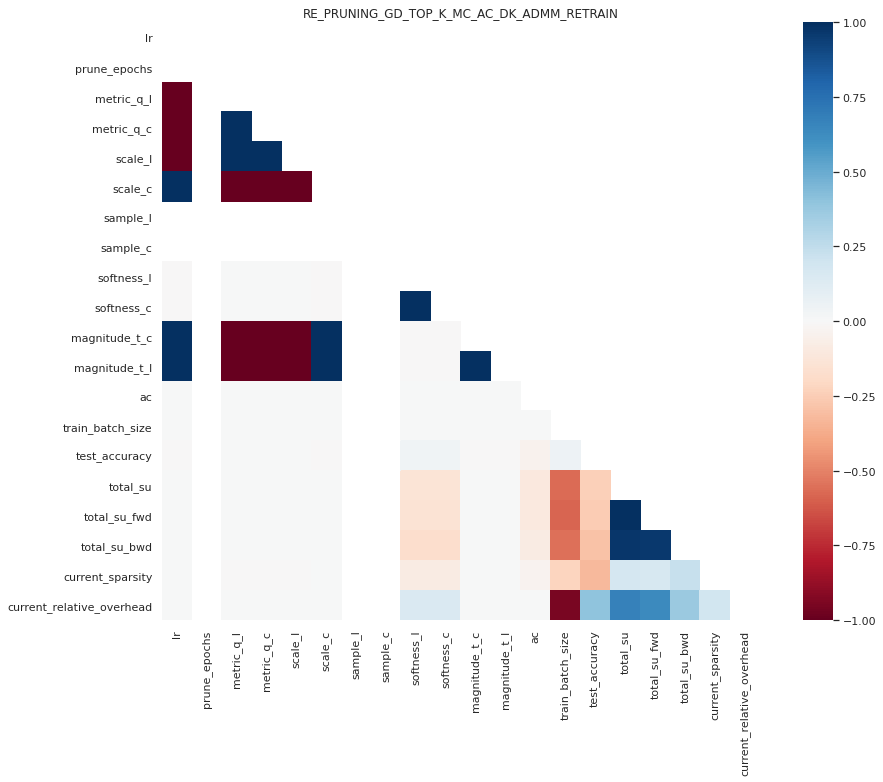

\begin{table}
\centering
\caption{re_pruning_gd_top_k_mc_ac_dk_admm_retrain}
\begin{tabular}{lrrrrr}
\toprule
{} & Count &    Mean &   Std &     Min &     Max \\
\midrule
\textbf{lr              } & 72.00 &    0.00 &  0.00 &    0.00 &    0.00 \\
\textbf{prune\_epochs    } & 72.00 &    0.00 &  0.00 &    0.00 &    0.00 \\
\textbf{metric\_q\_l      } & 72.00 &    0.05 &  0.00 &    0.05 &    0.05 \\
\textbf{metric\_q\_c      } & 72.00 &    0.05 &  0.00 &    0.05 &    0.05 \\
\textbf{scale\_l         } & 72.00 &    0.10 &  0.00 &    0.10 &    0.10 \\
\textbf{scale\_c         } & 72.00 &    0.01 &  0.00 &    0.01 &    0.01 \\
\textbf{sample\_l        } & 72.00 & 1000.00 &  0.00 & 1000.00 & 1000.00 \\
\textbf{sample\_c        } & 72.00 & 1000.00 &  0.00 & 1000.00 & 1000.00 \\
\textbf{softness\_l      } & 72.00 &    0.45 &  0.45 &    0.00 &    0.90 \\
\textbf{softness\_c      } & 72.00 &    0.45 &  0.45 &    0.00 &    0.90 \\
\textbf{magnitude\_t\_c   } & 72.00 &    0.00 &  0.00 &    0.00 &   

In [7]:
datasets = [
    'cifar10', 
    'cifar100', 
    'mnist',
    'imagenet_tiny',
    'imagenet_full',
]
models = [
    'resnet18', 
    'resnet20',
    'resnet32',
    'resnet34',
    'resnet50',
    'alexnet_s', 
    'alexnet',
    'lenet', 
    'mobilenet_v2', 
    'mobilenet_v3_s', 
    'vgg8',
    'vgg11', 
    'vgg13', 
    'vgg16'
         ]
best_results = {}
plt_corr = True
sns.set(rc={'figure.figsize':(1.33*11.7,1.33*8.27)})
sns.set_theme(style="white")


cross_eval(best_results, datasets, models, 'baseline', ['lr', 'epochs', 'train_batch_size'], ['test_accuracy'], plt_corr)


cross_eval(best_results, datasets, models, 'admm_intra', 
     ['lr', 'pre_epochs', 'epochs', 're_epochs', 'repeat', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 'admm_retrain', 
     ['lr', 'pre_epochs', 'epochs', 're_epochs', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)

cross_eval(best_results, datasets, models, 'gd_top_k', ['lr', 'k', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 'gd_top_k_mc', ['lr', 'k', 'se', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd',
      'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 'gd_top_k_mc_ac', ['lr', 'k', 'se', 'ac', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 'gd_top_k_mc_ac_dk', ['lr', 'k', 'se', 'ac', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd',
      'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 'gd_top_k_mc_ac_dk_admm_intra', 
     ['lr', 'k', 'se', 'ac', 'pre_epochs', 'epochs', 're_epochs', 'repeat', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 'gd_top_k_mc_ac_dk_admm_retrain',  
     ['lr', 'k', 'se', 'ac', 'pre_epochs', 'epochs', 're_epochs', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)


cross_eval(best_results, datasets, models, 're_pruning', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'l1', 'l2', 
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 're_pruning_ac', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'l1', 'l2', 'ac', 
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)


cross_eval(best_results, datasets, models, 're_pruning_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'repeat', 
                                                                     'pre_epochs', 'epochs', 're_epochs',
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 're_pruning_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 
                                                                       'pre_epochs', 'epochs', 're_epochs',
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 're_pruning_ac_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'ac', 'repeat',
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd',  
                            #'pre_epochs', 'epochs', 're_epochs',
      'current_sparsity', 'current_relative_overhead'], plt_corr)
cross_eval(best_results, datasets, models, 're_pruning_ac_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'ac', 
                                                                          'pre_epochs', 'epochs', 're_epochs',
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)



cross_eval(best_results, datasets, models, 're_pruning_gd_top_k_mc_ac_dk_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 
      'metric_q_c', 'scale_l', 'scale_c', 'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 
      'magnitude_t_l', 'ac', 'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 
      'total_su_bwd', 'current_sparsity', 'current_relative_overhead'], plt_corr)

cross_eval(best_results, datasets, models, 're_pruning_gd_top_k_mc_ac_dk_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 
      'metric_q_c', 'scale_l', 'scale_c', 'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 
      'magnitude_t_l', 'ac', 'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 
      'total_su_bwd', 'current_sparsity', 'current_relative_overhead'], plt_corr)

In [8]:
search_n, search_m, search_d = 're_pruning_gd_top_k_mc_ac_dk_admm_intra', 'resnet50', 'cifar10'
for name in best_results:
    if name == search_n:
        for model in best_results[name]['cfg']:
            if search_m == model:
                for data in best_results[name]['cfg'][model]:
                    if search_d == data:
                        if 'METADATA' in best_results[name]['cfg'][model][data]:
                            print(best_results[name]['cfg'][model][data]['METADATA'])
        #print(best_results[name]['cfg'])

{'EXPERIMENT': {'name': 're_pruning_gd_top_k_mc_ac_dk_admm_intra', 'model': 'resnet50', 'dataset': 'cifar10', 'train_batch_size': '256', 'test_batch_size': '1000'}, 'SPECIFICATION': {'num_classes': '10', 'lb': '45', 'k': '3', 'se': '3', 'ac': '4', 'lr': '1e-3', 'adam_eps': '1e-8', 'percent': '0.6, 0.6, 0.61, 0.61, 0.62, 0.62, 0.63, 0.64, 0.64, 0.65, 0.67, 0.68, 0.68, 0.69, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.72, 0.72, 0.72, 0.73, 0.73, 0.73, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.73, 0.72, 0.72, 0.71, 0.7, 0.7, 0.68, 0.68, 0.67, 0.65, 0.64, 0.64, 0.63, 0.62, 0.62, 0.61, 0.6, 0.6', 'alpha': '5e-4', 'rho': '1e-2', 'l1': 'False', 'l2': 'False', 'pre_epochs': '3', 'epochs': '3', 're_ep

In [9]:
import collections

cifar10+re_pruning_gd_top_k_mc_ac_dk_admm_intra+resnet18 train_loss
(42, 19404)
cifar10+baseline+resnet18 train_loss
(1, 19600)


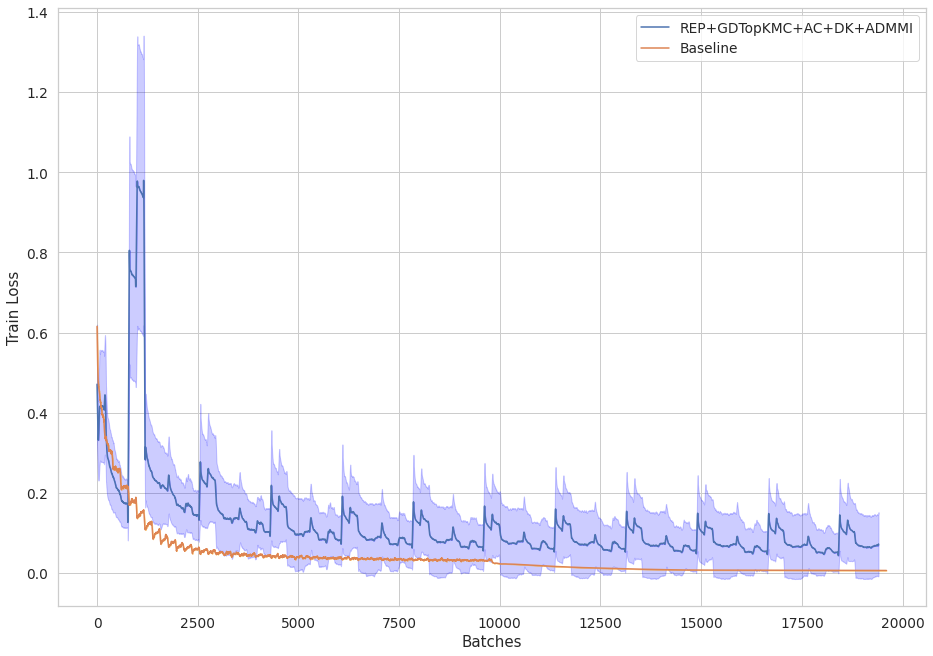

{'mnist+lenet': 0.9939, 'cifar10+alexnet_s': 0.7379000000000001, 'cifar10+resnet18': 0.7468000000000001, 'cifar100+alexnet_s': 0.3387, 'cifar100+mobilenet_v2': 0.3578, 'cifar10+mobilenet_v2': 0.6879, 'cifar100+mobilenet_v3_s': 0.2577, 'cifar10+mobilenet_v3_s': 0.6116, 'cifar100+resnet18': 0.4191, 'cifar10+resnet32': 0.7694, 'cifar100+vgg13': 0.3841, 'cifar10+resnet20': 0.7573, 'cifar100+resnet32': 0.4724, 'cifar10+vgg13': 0.7678, 'cifar100+vgg16': 0.3681, 'cifar10+vgg16': 0.8034, 'cifar100+vgg8': 0.3898, 'cifar10+vgg8': 0.7441, 'cifar10+resnet50': 0.7411, 'cifar100+vgg11': 0.3538, 'cifar10+vgg11': 0.6956, 'cifar100+resnet50': 0.3343}
cifar10+gd_top_k+resnet18
ΔAcc, C/F, P, FLOPs(I), FLOPs(T), G
0.01 0.0 0.0 0.0 0.09 0.74
0.01 0.0 0.0 0.0 0.19 0.78
0.01 0.0 0.0 0.0 0.1 0.74
0.01 0.0 0.0 0.0 0.07 0.71
0.0 0.0 0.0 0.0 0.17 0.78


cifar10+re_pruning_gd_top_k_mc_ac_dk_admm_intra+resnet18
ΔAcc, C/F, P, FLOPs(I), FLOPs(T), G
-0.01 0.9 0.9 0.48 0.67 0.92
-0.01 0.9 0.9 0.48 0.67 0.92
-0.01 0.9 

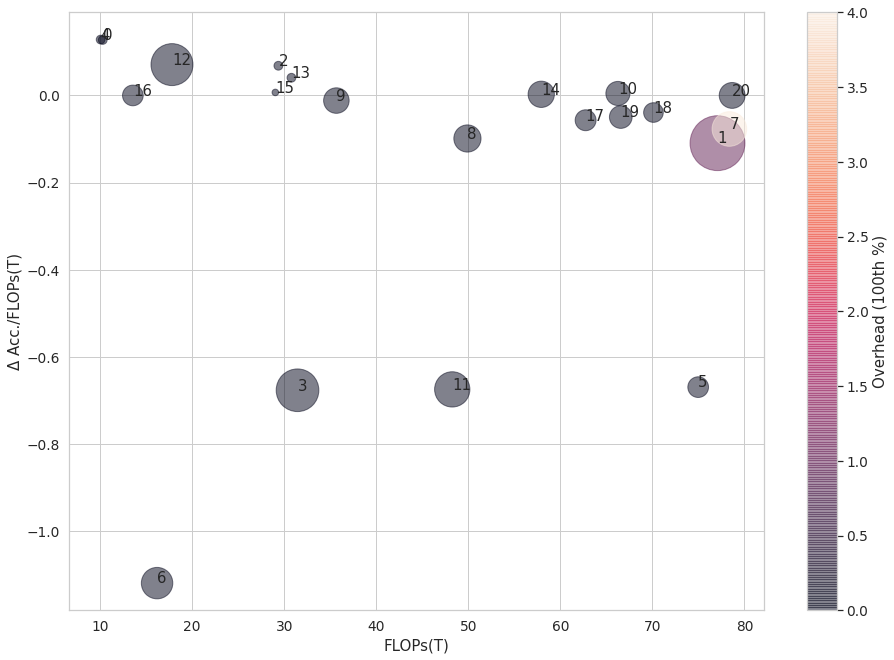

In [18]:
new_logdict = {}
for log in logs:
    for key in log['LOGDATA']:
        new_key = log['METADATA']['EXPERIMENT']['dataset'] + '+'
        new_key += log['METADATA']['EXPERIMENT']['name'] + '+'
        new_key += log['METADATA']['EXPERIMENT']['model']
        if log['LOGDATA']['test_accuracy'][-1] <= 0.1:
                continue
        if new_key not in new_logdict:
            new_logdict[new_key] = {}
        if key not in new_logdict[new_key]:
            new_logdict[new_key][key] = []
            
        if 'overhead' in key:
            #print(sum(log['LOGDATA'][key])/len(log['LOGDATA'][key]), flush=True)
            if ('_mc' in log['METADATA']['EXPERIMENT']['name'] and
                'gd' in log['METADATA']['EXPERIMENT']['name'] and not
                'admm' in log['METADATA']['EXPERIMENT']['name']):
                
                    idx = int((len(log['LOGDATA'][key])*
                           float(log['METADATA']['SPECIFICATION']['se'])/
                           float(log['METADATA']['SPECIFICATION']['epochs'])))+1
                    new_logdict[new_key][key].append(sum(log['LOGDATA'][key][:idx])/len(log['LOGDATA'][key]))
                    #print(log['METADATA']['EXPERIMENT']['name'], 
                    #      sum(log['LOGDATA'][key][:idx])/len(log['LOGDATA'][key]),
                    #      sum(log['LOGDATA'][key])/len(log['LOGDATA'][key]))
            else:
                new_logdict[new_key][key].append(sum(log['LOGDATA'][key])/len(log['LOGDATA'][key]))
        elif 'gradient' in key:
            new_logdict[new_key][key].append(sum(log['LOGDATA'][key])/len(log['LOGDATA'][key]))
        elif 'loss' in key:
            new_logdict[new_key][key].append(log['LOGDATA'][key])
        else:
            new_logdict[new_key][key].append(log['LOGDATA'][key][-1])
        

base_dict = {}
for key in new_logdict:
    for i in range(0, len(new_logdict[key]['test_accuracy'])):
        if new_logdict[key]['test_accuracy'][i] > 1:
            new_logdict[key]['test_accuracy'][i]*=1e-2
    if 'baseline':
        base_dict[key.split('+')[0]+'+'+key.split('+')[2]]=max(new_logdict[key]['test_accuracy'])#[idx[0]]
        
sns.set(font_scale=1.25)
sns.set_style("whitegrid")
from scipy.signal import savgol_filter
for new_key in new_logdict:
    if ('resnet18' in new_key and not 
        'cifar100' in new_key and 
        ('baseline' in new_key or 're_pruning_gd_top_k_mc_ac_dk_admm_intra' in new_key)):
        for key in new_logdict[new_key]:
            if 'train_loss' in key:
                print(new_key, key)
                np.array(new_logdict[new_key][key])
                m = np.array(new_logdict[new_key][key])#.mean(axis=0)
                print(m.shape)
                if len(m.shape) >=2:
                    if 're_pruning_gd_top_k_mc_ac_dk_admm_intra' in new_key:
                        mmean = savgol_filter(m.mean(axis=0), 51, 3)#*1000
                        mstd = savgol_filter(m.std(axis=0), 51, 3)#*1000
                        plt.ylabel('Train Loss')
                        plt.xlabel('Batches')
                        plt.plot(mmean, label='REP+GDTopKMC+AC+DK+ADMMI')
                        plt.fill_between(np.arange(len(mmean)), mmean+mstd, mmean, alpha=0.2, color='blue')
                        plt.fill_between(np.arange(len(mmean)), mmean-mstd, mmean, alpha=0.2, color='blue')
                    else:
                        mmean = savgol_filter(m.mean(axis=0), 51, 3)/1000
                        mstd = savgol_filter(m.std(axis=0), 51, 3)/1000
                        plt.ylabel('Train Loss')
                        plt.xlabel('Batches')
                        plt.plot(mmean, label='Baseline')
                        plt.fill_between(np.arange(len(mmean)), mmean+mstd, mmean, alpha=0.2, color='orange')
                        plt.fill_between(np.arange(len(mmean)), mmean-mstd, mmean, alpha=0.2, color='orange')
                    #plt.show()
                break
#plt.yscale('log')
plt.legend()
plt.show()                
                

print(base_dict, flush = True)

n = 5
prec = 2
x = []
y = []
area = []
names = []
colors = []
for key in new_logdict:
    if (not 'baseline' in key and '+resnet' in key):# and not 'cifar100' in key):
       #and 're_pruning_gd_top_k_mc_ac_dk_admm_intra' in key):#('+resnet' in key or '+alexnet' in key or '+lenet' in key):
        print(key)
        idx = sorted(range(len(new_logdict[key]['test_accuracy'])), 
                     key=lambda i: new_logdict[key]['test_accuracy'][i])[-n:]
        #idx = idx[:10]
        idx.reverse()
        print("{}Acc, C/F, P, FLOPs(I), FLOPs(T), G".format(chr(916)))
        
        #y.append(round((1-1/new_logdict[key]['total_su'][0])/
        #         #(new_logdict[key]['test_accuracy'][0]-base_dict[key.split('+')[0]+'+'+key.split('+')[2]]),prec))
        #        (new_logdict[key]['test_accuracy'][0]/base_dict[key.split('+')[0]+'+'+key.split('+')[2]]),prec))
        #y.append(round((new_logdict[key]['test_accuracy'][0])/new_logdict[key]['total_su'][0], prec))
        y.append(
            (new_logdict[key]['test_accuracy'][0]-base_dict[key.split('+')[0]+'+'+key.split('+')[2]])/(1-1/new_logdict[key]['total_su'][0]))             
        
        x.append(round((1-1/new_logdict[key]['total_su'][0])*100,prec))
        
        area.append(round(new_logdict[key]['test_accuracy'][0]/
                 (1-new_logdict[key]['current_sparsity'][0])*100+1,prec))
        
        colors.append(int(round(new_logdict[key]['current_relative_overhead'][0]*100*100, prec)))#/
                                #max(new_logdict[key]['current_relative_overhead'])*100,prec)))
        
        name_candidate = key.split('+')[1]
        name_candidate = name_candidate.replace('re_pruning', 'REP')
        name_candidate = name_candidate.replace('gd_top_k_mc', 'GDTopKMC')
        name_candidate = name_candidate.replace('gd_top_k', 'GDTopK')
        name_candidate = name_candidate.replace('ac', 'AC')
        name_candidate = name_candidate.replace('dk', 'DK')
        name_candidate = name_candidate.replace('admm_retrain', 'ADMMR')
        name_candidate = name_candidate.replace('admm_intra', 'ADMMI')
        name_candidate = name_candidate.replace('_', '+')
        names.append(name_candidate)
        for i in idx:
            #print(new_logdict[key].keys()) #current_channel_sparsity', 'current_linear_sparsity #current_relative_overhead'
            print(round(new_logdict[key]['test_accuracy'][i]-base_dict[key.split('+')[0]+'+'+key.split('+')[2]],prec), 
                  round(new_logdict[key]['current_channel_sparsity'][i],prec),
                  round(new_logdict[key]['current_sparsity'][i],prec),
                  round(1-1/new_logdict[key]['current_su_fwd'][i],prec),
                  round(1-1/new_logdict[key]['total_su'][i],prec),
                  round(new_logdict[key]['current_gradient_sparsity'][i],prec),
                  #round(new_logdict[key]['current_relative_overhead'][i]*1e5, prec),
                  #round(1-1/new_logdict[key]['current_su_bwd'][i],prec),
                  #round(new_logdict[key]['total_su'][i],prec),
                  #round(new_logdict[key]['current_sparsity'][i],prec))+
                  )
                  #round(new_logdict[key]['current_relative_overhead'][i],prec))
        print('\n')
    #for subkey in new_logdict[key]:
    #    if not 'features' in subkey and not 'weight' in subkey:
            
sns.set(font_scale=1.25)
sns.set_style("whitegrid")

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.colorbar(orientation="vertical", label="Overhead (100th %)")
for i, txt in enumerate(names):
    plt.annotate(i, (x[i], y[i]))
print([(i,txt) for i, txt in enumerate(names)])

plt.ylabel("{} Acc./FLOPs(T)".format(chr(916)))
plt.xlabel('FLOPs(T)')
#plt.legend()
plt.show()

In [11]:
greek_letterz=[(code, chr(code)) for code in range(945,970)]

print(greek_letterz)
print(chr(916))

[(945, 'α'), (946, 'β'), (947, 'γ'), (948, 'δ'), (949, 'ε'), (950, 'ζ'), (951, 'η'), (952, 'θ'), (953, 'ι'), (954, 'κ'), (955, 'λ'), (956, 'μ'), (957, 'ν'), (958, 'ξ'), (959, 'ο'), (960, 'π'), (961, 'ρ'), (962, 'ς'), (963, 'σ'), (964, 'τ'), (965, 'υ'), (966, 'φ'), (967, 'χ'), (968, 'ψ'), (969, 'ω')]
Δ


datasets = [
    'cifar10', 
    'cifar100', 
    'mnist',
    'imagenet'
]
models = [
    'resnet18', 
    'alexnet_s', 
    'lenet', 
    'mobilenet_v2', 
    'mobilenet_v3', 
    'vgg8',
    'vgg11', 
    'vgg13', 
    'vgg16'
         ]
plt_corr = False

for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 'baseline', ['lr', 'epochs', 'train_batch_size'], ['test_accuracy'], plt_corr)


for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 'admm_intra', 
             ['lr', 'pre_epochs', 'epochs', 're_epochs', 'repeat', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'admm_retrain', 
             ['lr', 'pre_epochs', 'epochs', 're_epochs', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)

for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 'gd_top_k', ['lr', 'k', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc', ['lr', 'k', 'se', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc_ac', ['lr', 'k', 'se', 'ac', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc_ac_dk', ['lr', 'k', 'se', 'ac', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc_ac_dk_admm_intra', 
             ['lr', 'k', 'se', 'ac', 'pre_epochs', 'epochs', 're_epochs', 'repeat', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc_ac_dk_admm_retrain',  
             ['lr', 'k', 'se', 'ac', 'pre_epochs', 'epochs', 're_epochs', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)


for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 're_pruning', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'l1', 'l2', 
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 're_pruning_ac', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'l1', 'l2', 'ac', 
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)


for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 're_pruning_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'repeat',
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 're_pruning_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 're_pruning_ac_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'ac', 'repeat',
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 're_pruning_ac_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'ac', 
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)


for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 're_pruning_gd_top_k_mc_ac_dk_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 
              'metric_q_c', 'scale_l', 'scale_c', 'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 
              'magnitude_t_l', 'l1', 'l2', 'ac', 'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 
              'total_su_bwd', 'current_sparsity', 'current_relative_overhead'], False)